In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    savefig,
)
from rl_analysis.io.df import get_closed_loop_parquet_columns

import pandas as pd
import numpy as np
import os
import seaborn as sns

## Load in pre-processed data

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
figure_cfg = analysis_config["figures"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]

In [5]:
fname = os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet")
cols = get_closed_loop_parquet_columns(fname, pcs=False, likes=True)

In [6]:
feedback_df = pd.read_parquet(
    fname,
    filters=[
        (
            "experiment_type",
            "in",
            [
                "reinforcement",
            ],
        ),
    ],
    columns=cols,
).sort_index()

In [7]:
feedback_df = feedback_df.loc[feedback_df["session_number"].isin([-1, 0, 1, 2])].copy()

In [8]:
learner_dct = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)
learners = learner_dct["snc (axon)"]["learners"]

In [9]:
like_cols = feedback_df.filter(regex="likes*").columns

In [10]:
feedback_df = feedback_df.loc[
    (feedback_df["area"].isin(["snc (axon)", "ctrl"]))
    & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
].copy()

In [11]:
feedback_df["predicted_syllable"] = feedback_df["predicted_syllable"].astype("Int8")
feedback_df.loc[feedback_df["predicted_syllable"] < 0, "predicted_syllable"] = np.nan
feedback_df["predicted_syllable"] = feedback_df.groupby("uuid")[
    "predicted_syllable"
].fillna(method="ffill", limit=10)

feedback_df.dropna(subset=["predicted_syllable"], inplace=True)
feedback_df.rename(columns={"predicted_syllable": "syllable"}, inplace=True)

In [12]:
feedback_df["syllable"] = feedback_df["syllable"].astype("int8")

codes, uniqs = pd.factorize(
    list(zip(feedback_df["uuid"], feedback_df["session_number"]))
)
feedback_df["uniq_id"] = codes

# syllable number
feedback_df["syllable_number"] = feedback_df.groupby("uniq_id")["syllable"].transform(
    lambda x: (x.diff() != 0).cumsum()
)
feedback_df.loc[
    feedback_df["session_number"].isin([-1, 0, 3, 4]), "feedback_status"
] = -1

In [13]:
feedback_df.loc[
    feedback_df["session_number"].isin([-1, 0]), "session_type"
] = "baseline"
feedback_df.loc[feedback_df["session_number"].isin([1, 2]), "session_type"] = "stim"

In [14]:
tqdm.pandas()

In [15]:
def wiener_entropy(x, eps=1e-30, axis=1):
    use_x = x.copy()
    use_x -= use_x.min()
    use_x += eps
    use_x /= use_x.sum()
    if axis is None:
        ent = np.exp(np.mean(np.log(use_x))) / np.mean(use_x)
    else:
        ent = np.exp(np.mean(np.log(use_x), axis=axis)) / np.mean(use_x, axis=axis)

    return ent
    # return pd.Series(data=ent, index=x.index)

In [16]:
def simple_entropy(y, eps=1e-6, axis=None):
    # nans are skipped here...

    yhat = y.values + eps
    with np.errstate(invalid="ignore", divide="ignore"):
        if axis is None:
            yhat = yhat / np.nansum(yhat)
            return -np.nansum(yhat * np.log2(yhat))
        else:
            yhat = yhat / np.nansum(yhat, axis=axis, keepdims=True)
            return -np.nansum(yhat * np.log2(yhat), axis=axis)

In [17]:
metrics = {
    "max_entropy": lambda x: simple_entropy(x.max(axis=0)),
    "entropy": lambda x: simple_entropy(np.power(10, x), axis=1).mean(),
    "max_std": lambda x: x.max(axis=0).std(),
    "ave_std": lambda x: x.std(axis=1).mean(),
    "ave_max": lambda x: x.max(axis=1).mean(),
    # "max_entropy": lambda x: wiener_entropy(x.max(axis=0), axis=None),
    # "wiener_entropy": lambda x: wiener_entropy(x).mean(),
}

In [18]:
features = {}

In [19]:
for k, v in tqdm(metrics.items()):
    if k not in features.keys():
        _tmp = (
            feedback_df.groupby(["area", "mouse_id", "session_type"])[like_cols]
            .progress_apply(v)
            .rename(k)
        )
        features[k] = _tmp
    else:
        continue

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [20]:
features_df = pd.concat(list(features.values()), axis=1)

In [21]:
zfeatures_df = features_df.copy()

In [22]:
zfeatures_df[list(features.keys())] = zfeatures_df.groupby("area")[
    list(features.keys())
].transform(lambda x: (x - x.mean()) / x.std())

In [23]:
zfeatures_df = zfeatures_df.melt(ignore_index=False).reset_index()

In [24]:
setup_plotting_env()

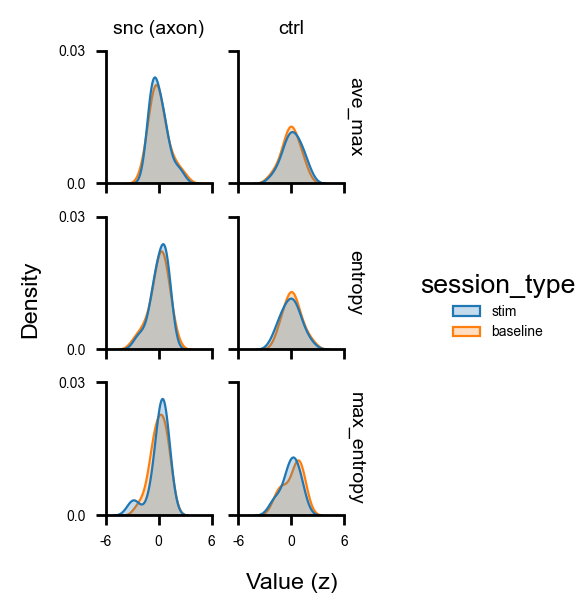

In [25]:
g = sns.displot(
    data=zfeatures_df,
    x="value",
    hue="session_type",
    col="area",
    col_order=["snc (axon)", "ctrl"],
    row="variable",
    row_order=["ave_max", "entropy", "max_entropy"],
    fill=True,
    height=1,
    aspect=1,
    hue_order=["stim", "baseline"],
    kind="kde",
    bw_adjust=1.2,
    facet_kws={"sharex": True, "sharey": True, "margin_titles": True},
)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set(xlabel="", ylabel="")
clean_ticks(g.axes.flat[0], "y", precision=2)
clean_ticks(g.axes.flat[0], "X", precision=0, dtype=int)
g.fig.subplots_adjust(hspace=0.25, wspace=0.25)
g.fig.supxlabel("Value (z)")
g.fig.supylabel("Density")
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "fractionation_analysis"),
    bbox_inches="tight",
)

In [26]:
stats_df = zfeatures_df.set_index(["session_type", "area", "variable"])

In [27]:
from scipy.stats import ks_2samp

In [30]:
compare_areas = ["snc (axon)", "ctrl"]
compare_variables = stats_df.index.get_level_values("variable").unique().tolist()

In [31]:
use_test = ks_2samp

In [32]:
stats = {}

In [33]:
for _area in compare_areas:
    for _var in compare_variables:
        comparison = f"{_area} {_var} stim-baseline"
        dat1 = stats_df.loc["stim", _area, _var]["value"]
        dat2 = stats_df.loc["baseline", _area, _var]["value"]
        n1 = len(dat1)
        n2 = len(dat2)
        stat, p = use_test(dat1, dat2)
        stats[comparison] = {}
        stats[comparison]["stat"] = stat
        stats[comparison]["p"] = p
        stats[comparison]["n1"] = n1
        stats[comparison]["n2"] = n2
        stats[comparison]["n_definition"] = "mouse average"
        stats[comparison]["test"] = str(use_test.__name__)

/tmp/ipykernel_1562152/2541857243.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  dat1 = stats_df.loc["stim", _area, _var]["value"]
/tmp/ipykernel_1562152/2541857243.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  dat2 = stats_df.loc["baseline", _area, _var]["value"]


In [34]:
with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "stats_fractionation.toml"), "w"
) as f:
    toml.dump(stats, f)